Python Questions:Python Question - 1:
Write Python code to fetch historical health care R&D spending data from a given data source and calculate the year-over-year percentage change for each year over the past four years.Python Question - 2:
Create a Python script that uses matplotlib library to generate a line chart or bar chart showing the trend in health care R&D spending for a specific company listed on the New York Stock Exchange over the past four years.SQL Questions:SQL Question - 3:
write an SQL query to retrieve the total health care R&D spending for all companies for each of the past four years.SQL Question - 4:
Write an SQL query to find the top three companies listed on the New York Stock Exchange with the highest percentage increase in health care R&D spending .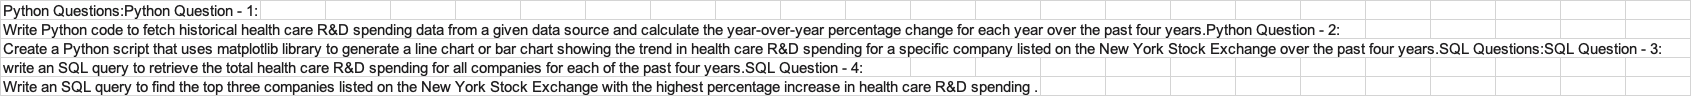

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson

In [96]:
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)

In [156]:
# Load data
df = pd.read_excel("../data/raw/companies.xlsx")

In [157]:
def normalize_column_names(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('.', '')
    return df

In [166]:
# Normalize columns names
df_cleaned = normalize_column_names(df)
df_cleaned["years"] = df_cleaned["years"].replace("Year ", "", regex=True)
display(df_cleaned.head())
display(df_cleaned.dtypes)

# Filter columns that are useful to us
df_filtered = pd.DataFrame(df_cleaned, columns=['ticker_symbol', 'years', 'period_ending', 'research_and_development', 'gics_sector'])
# Make sure we only have the health care sector companies
df_filtered = df_filtered.loc[df_filtered['gics_sector'] == 'Health Care']
# Sort by ticket symbol and years early on
df_filtered = df_filtered.sort_values(['ticker_symbol', 'years'], ascending=True)
display(df_filtered.head())

/var/folders/t8/k_p89pr11hl5tqbxsmphfkyr0000gp/T/ipykernel_7475/2398183133.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('.', '')
/var/folders/t8/k_p89pr11hl5tqbxsmphfkyr0000gp/T/ipykernel_7475/2398183133.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('.', '')
/var/folders/t8/k_p89pr11hl5tqbxsmphfkyr0000gp/T/ipykernel_7475/2398183133.py:2: FutureWarning: The default value of regex will change from True to False in a futur

,ticker_symbol,years,period_ending,total_revenue,cost_of_goods_sold,sales_general_and_admin,research_and_development,other_operating_items,gics_sector,gics_sub_industry
0,AAL,1,2012-12-31,24855000000,10499000000,12977000000,0,845000000,Industrials,Airlines
1,AAL,2,2013-12-31,26743000000,11019000000,12913000000,0,853000000,Industrials,Airlines
2,AAL,3,2014-12-31,42650000000,15620000000,20686000000,0,1295000000,Industrials,Airlines
3,AAL,4,2015-12-31,40990000000,11096000000,21275000000,0,1364000000,Industrials,Airlines
4,AAP,1,2012-12-29,6205003000,3106967000,2440721000,0,0,Consumer Discretionary,Automotive Retail


ticker_symbol                       object
years                               object
period_ending               datetime64[ns]
total_revenue                        int64
cost_of_goods_sold                   int64
sales_general_and_admin              int64
research_and_development             int64
other_operating_items                int64
gics_sector                         object
gics_sub_industry                   object
dtype: object

,ticker_symbol,years,period_ending,research_and_development,gics_sector
12,ABBV,1,2012-12-31,2778000000,Health Care
13,ABBV,2,2013-12-31,2855000000,Health Care
14,ABBV,3,2014-12-31,3297000000,Health Care
15,ABBV,4,2015-12-31,4285000000,Health Care
16,ABC,1,2013-09-30,0,Health Care


In [167]:
# Yearly spending by companies from the health sector
yearly_company_spending = df_filtered.groupby(['ticker_symbol', 'years']).sum().reset_index()
display(yearly_company_spending)

/var/folders/t8/k_p89pr11hl5tqbxsmphfkyr0000gp/T/ipykernel_7475/4270605480.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly_company_spending = df_filtered.groupby(['ticker_symbol', 'years']).sum().reset_index()


,ticker_symbol,years,research_and_development
0,ABBV,1,2778000000
1,ABBV,2,2855000000
2,ABBV,3,3297000000
3,ABBV,4,4285000000
4,ABC,1,0
5,ABC,2,0
6,ABC,3,0
7,ABC,4,0
8,ABT,1,1461000000
9,ABT,2,1371000000


In [178]:
# Aggregated yearly spending change across the companies
yearly_spending = df_filtered.groupby('years')["research_and_development"].sum().reset_index()
yearly_spending["spending_change"] = yearly_spending['research_and_development'].pct_change()
# Fix NaN
yearly_spending = yearly_spending.fillna(0)
# Round off change
yearly_spending["spending_change"] = yearly_spending["spending_change"].round(4)
display(yearly_spending)

,years,research_and_development,spending_change
0,1,47801208000,0.0000
1,2,48340505000,0.0113
2,3,52340604000,0.0827
3,4,55640583000,0.0630


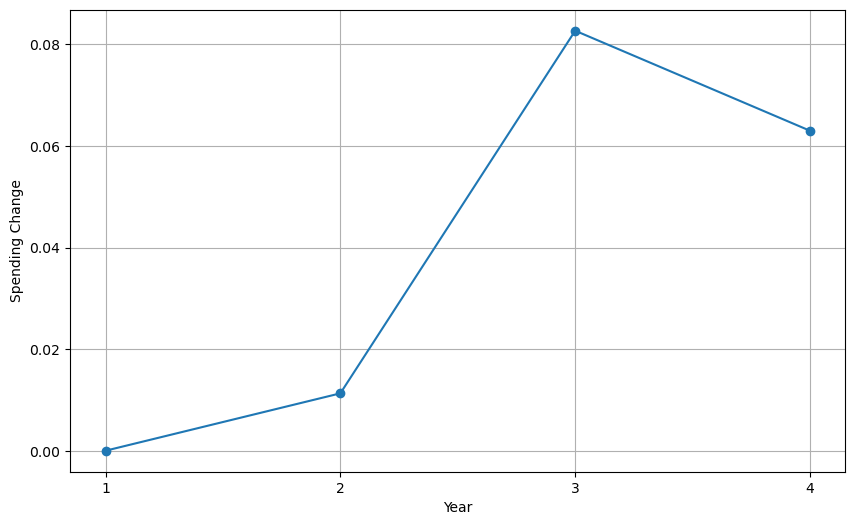

In [179]:
# Plotting YoY R&D spending change in the health sector
plt.figure(figsize=(10,6))
plt.plot(yearly_spending['years'], yearly_spending['spending_change'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Spending Change')
plt.grid(True)
plt.show()